<a href="https://colab.research.google.com/github/CharlemagneBrain/Transfer_Learning/blob/main/Transfer_Learning_FE_FT_SU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Première partie**: Extraction de caractéristiques ⚒

=> Consiste à prendre les poids sous jacents qu'un modèle préentrainé a appris et à ajuster ses sorties pour qu'elles plus adaptées à notre problème.

### Téléchargeons nos données 

In [ ]:
import zipfile
import os

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-01-08 11:27:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.251.107.128, 74.125.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   109MB/s    in 1.5s    

2023-01-08 11:27:08 (109 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



### Combien d'images par dossiers avons nous ?

In [ ]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/"):
  print(f"Il y a {len(dirnames)} dossiers et {len(filenames)} images dans {dirpath} ")

Il y a 2 dossiers et 0 images dans 10_food_classes_10_percent/ 
Il y a 10 dossiers et 0 images dans 10_food_classes_10_percent/train 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/fried_rice 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/pizza 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/chicken_wings 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/ice_cream 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/steak 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/sushi 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/hamburger 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/ramen 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/grilled_salmon 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/chicken_curry 
Il y a 10 dossiers et 0 images dans 10_food_classes_10_percent/test 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Le paramètre rescale, ainsi que 1/255, revient à dire "divisez toutes les valeurs des pixels par 255". 
Ainsi, toutes les images sont importées et leurs valeurs de pixels sont normalisées (converties pour être comprises entre 0 et 1).

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Entrainement:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Test:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Entrainement:
Found 750 images belonging to 10 classes.
Test:
Found 2500 images belonging to 10 classes.


### Création d'un callback TensorBoard

Les callbacks 🆕 sont des fonctionnalités supplémentaires que l'on peut ajouter à vos modèles et qui seront exécutées pendant ou après la formation. Voici quelques-uns des callbacks les plus populaires :

- ⛓ Suivi des expériences avec TensorBoard (Experiment tracking with TensorBoard):  enregistrer les performances de plusieurs modèles, puis visualiser et comparer ces modèles de manière visuelle sur TensorBoard (un tableau de bord pour inspecter les paramètres des réseaux neuronaux). Utile pour comparer les résultats de différents modèles sur vos données.

- 🎛 Point de contrôle du modèle(Model checkpointing) : enregistrer notre modèle au fur et à mesure qu'il s'entraîne afin de pouvoir interrompre l'entraînement si nécessaire et revenir pour reprendre là où nous en étions. Utile si la formation prend beaucoup de temps et ne peut pas être effectuée en une seule séance.

- 🛑 Arrêt anticipé (Early stopping) :  laisser notre modèle s'entraîner pendant une durée arbitraire et faire en sorte qu'il s'arrête automatiquement lorsqu'il ne s'améliore plus. Cette option est utile lorsque nous disposons d'un grand ensemble de données et que nous ne savons pas combien de temps la formation prendra.

On peut accéder à la fonction de rappel TensorBoard en utilisant `tf.keras.callbacks.TensorBoard()`.

Sa principale fonctionnalité est l'enregistrement des mesures de performance de la formation d'un modèle dans un répertoire log_dir spécifié.

💡 Par défaut, les journaux sont enregistrés toutes les époques en utilisant le paramètre `update_freq='epoch'`. Il s'agit d'une bonne valeur par défaut, car le suivi des performances du modèle trop souvent peut ralentir la formation du modèle.


🔑 Remarque : nous créons une fonction pour créer une callback TensorBoard car, comme nous le verrons plus tard, chaque modèle a besoin de sa propre instance de callback TensorBoard (la fonction en créera donc une nouvelle à chaque exécution).



dirname = répertoire général des journaux
experiment_name = nom de l'expérience 

Par exemple, si dirname est "logs" et experiment_name est "exp1", log_dir pourrait être "logs/exp1/20210301-124532".

In [ ]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Sauvegarde fichiers log dans: {log_dir}")
  return tensorboard_callback

### Création de model avec Tensorflow Hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Prend une URL de Hub TensorFlow et crée un modèle Keras Sequential avec celle-ci.
  
  Arguments :
    model_url (str) : Une URL d'extraction de caractéristiques de TensorFlow Hub.
    num_classes (int) : Nombre de neurones de sortie dans la couche de sortie,
      doit être égal au nombre de classes cibles, par défaut 10.

  Retourne :
    Un modèle séquentiel Keras non compilé, avec model_url comme couche
    extracteur de caractéristiques et une couche de sortie dense avec des sorties num_classes.

In [ ]:

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
def create_model(model_url, num_classes=10):
  
  # Modèle prétrainé
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, 
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
  # Creation de notre propre modèle
  model = tf.keras.Sequential([
    feature_extractor_layer, 
    layers.Dense(num_classes, activation='softmax', name='output_layer') # creation de notre propre couche     
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)


resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Sauvegarde fichiers log dans: tensorflow_hub/resnet50V2/20230108-112723
Epoch 1/5
24/24 [==============================] - 30s 777ms/step - loss: 2.0117 - accuracy: 0.3280 - val_loss: 1.2119 - val_accuracy: 0.6240
Epoch 2/5
24/24 [==============================] - 16s 697ms/step - loss: 0.9395 - accuracy: 0.7307 - val_loss: 0.8449 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 17s 733ms/step - loss: 0.6472 - accuracy: 0.8200 - val_loss: 0.7400 - val_accuracy: 0.7672
Epoch 4/5
24/24 [==============================] - 16s 695ms/step - loss: 0.4918 - accuracy: 0.8720 - val_loss: 0.7121 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 16s 708ms/step - loss: 0.3993 - accuracy: 0.8933 - val_loss: 0.6788 - val_accuracy: 0.7788


In [ ]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Perte')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Précision')
  plt.xlabel('Epochs')
  plt.legend();


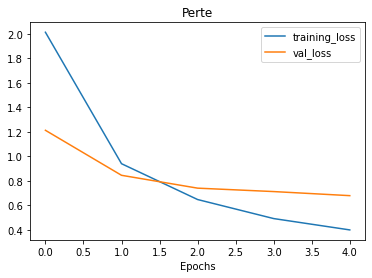

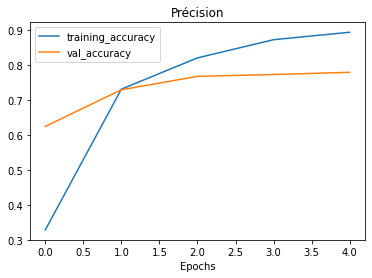

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Faisons de même pour le modèle EfficientNet

In [ ]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

efficientnet_history = efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetB0")]
)

Sauvegarde fichiers log dans: tensorflow_hub/efficientnetB0/20230108-112914
Epoch 1/5
24/24 [==============================] - 27s 747ms/step - loss: 1.8426 - accuracy: 0.4453 - val_loss: 1.2938 - val_accuracy: 0.7372
Epoch 2/5
24/24 [==============================] - 16s 681ms/step - loss: 1.0645 - accuracy: 0.7507 - val_loss: 0.8621 - val_accuracy: 0.8308
Epoch 3/5
24/24 [==============================] - 16s 674ms/step - loss: 0.7567 - accuracy: 0.8280 - val_loss: 0.6901 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 16s 679ms/step - loss: 0.6066 - accuracy: 0.8573 - val_loss: 0.6062 - val_accuracy: 0.8616
Epoch 5/5
24/24 [==============================] - 16s 688ms/step - loss: 0.5158 - accuracy: 0.8867 - val_loss: 0.5537 - val_accuracy: 0.8664


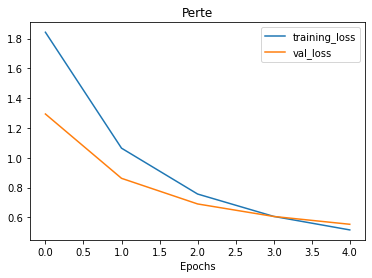

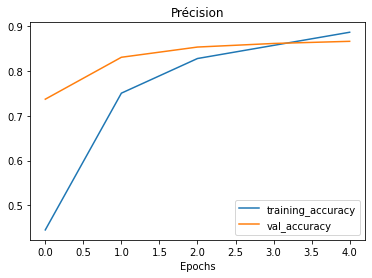

In [ ]:
plot_loss_curves(efficientnet_history)

D'après les courbes de perte du modèle EfficientNetB0, il semble que si nous continuions à entraîner notre modèle plus longtemps, il pourrait s'améliorer encore plus.

In [ ]:
# Regardons le résumé
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________



## Comparaison des modèles à l'aide de TensorBoard

Le téléchargement des résultats sur TensorBoard.dev permet de suivre et de partager plusieurs expériences de modélisation différentes. Ainsi, si on doit montrer les résultats à quelqu'un, on peut lui envoyer un lien vers notre TensorBoard.dev ainsi que le cahier Colab qui l'accompagne.

### Téléchargement d'expériences vers TensorBoard
Pour télécharger une série de journaux TensorFlow vers TensorBoard, nous pouvons utiliser la commande suivante :

Télécharger les enregistrements de TensorBoard dev
```python
  !tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \ 
    --description "Comparaison de deux architectures différentes de modèles d'extraction de caractéristiques du Hub TF en utilisant 10% des images d'entraînement" \ 
    --une_image
```
Où :

- logdir est le répertoire de téléchargement cible
- name est le nom de l'expérience
- description est une brève description de l'expérience
- one_shot quitte l'uploader TensorBoard une fois le téléchargement terminé.



In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparaison de deux architectures différentes de modèles d'extraction de caractéristiques du Hub TF en utilisant 10% des images d'entraînement" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


In [ ]:
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


## **Deuxième Partie :** Ajustement Fin

=> Consiste à prendre les poids du modèle préentrainé et de les adapter au problème . Cela signifie généralement l'entrainement de nombreuses ou de toutes les couches du modèle préentrainé. D'où il est utile lorsqu'on dispose d'un grand ensemble de données, et que  ces dernières sont légèrement différentes de celles sur lesquelles le modèle préentrainé a été formé. <br/>

**NB** : ***Transfer Learning par extraction de caractéristiques vs Transfer Learning par réglage fin***: <br/>
La principale différence entre les deux est qu'en cas d'ajustement fin, davantage de couches du modèle pré-entraîné sont dégelées et ajustées sur des données personnalisées. Ce réglage fin nécessite généralement plus de données que l'extraction de caractéristiques pour être efficace. <br/> 

Nous allons importer des fonctions qui vont nous aider à aller plus vite vus que l'on vas les utiliser tout au lond du projet. Elles proviennent de la formation de deep learning de zero to mastery.





In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2023-01-08 11:32:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-08 11:32:47 (88.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2023-01-08 11:32:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   183MB/s    in 0.9s    

2023-01-08 11:32:49 (183 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

Nous allons cette fois ci utiliser `tf.keras.preprocessing.image_dataset_from_directory()` qui fonctionne comme `flow_from_directory` de `ImageDataGenerator`. <br/>
Le principal avantage de cette méthode est que l'API tf.data.Dataset est beaucoup plus efficace (plus rapide) que l'API ImageDataGenerator, ce qui est primordial pour les grands ensembles de données.

In [ ]:
IMG_SIZE = (224, 224)

train_data_10_percent_ft = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size=IMG_SIZE,
    label_mode = "categorical",
    batch_size = 32
)

test_data_10_percent_ft = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size = IMG_SIZE,
    label_mode="categorical"
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent_ft

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent_ft.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for image, label in train_data_10_percent_ft.take(1):
  print(image, label)
  print(image.shape)

tf.Tensor(
[[[[ 34.571426    32.571426    35.571426  ]
   [ 32.668365    30.668365    33.668365  ]
   [ 24.          22.          25.        ]
   ...
   [ 12.137741    16.137741    19.137741  ]
   [  8.81119     12.81119     15.81119   ]
   [  5.999965     6.999965    10.999965  ]]

  [[ 14.42857     12.42857     15.42857   ]
   [ 12.499998    10.499998    13.499998  ]
   [ 11.183673     9.183673    12.183673  ]
   ...
   [ 14.484652    15.484652    19.484652  ]
   [  9.923455    10.923455    14.923455  ]
   [  6.571394     7.571394    11.571394  ]]

  [[ 12.          10.          15.        ]
   [ 12.198979    10.198979    15.198979  ]
   [ 13.          11.          16.        ]
   ...
   [ 14.596922    13.42855     18.42855   ]
   [ 12.142844    10.928558    15.928558  ]
   [ 11.214286    10.          15.        ]]

  ...

  [[153.56651    153.78078    145.78078   ]
   [145.07124    144.49977    138.85698   ]
   [ 28.606323    27.988935    24.249159  ]
   ...
   [114.50537    100.362

### Modèle 0 : construction d'un modèle d'apprentissage par transfert à l'aide de l'API fonctionnelle Keras

Nous allons utiliser le module `tf.keras.applications` qui contient une série de modèles de vision par ordinateur déjà entraînés (sur ImageNet) ainsi que l'API fonctionnelle Keras pour construire notre modèle.

Voici les étapes que l'on suivra :    

1. Instancier un objet de modèle de base pré-entraîné en choisissant un modèle cible tel que EfficientNetB0 dans tf.keras.applications, en réglant le paramètre `include_top` sur `False` (car nous allons créer nos propres top, qui sont les couches de sortie du modèle).

2. Définir l'attribut `trainable` du modèle de base à False pour geler tous les poids du modèle pré-entraîné.

3. Définir une couche d'entrée pour notre modèle, par exemple, quelle forme de données notre modèle doit-il attendre.

4. (Facultatif) Normaliser les entrées de notre modèle si nécessaire. Certains modèles de vision par ordinateur, tels que ResNetV250, exigent que leurs entrées soient comprises entre 0 et 1.

5. Transmettre les entrées au modèle de base.

6. Mettre en commun les sorties du modèle de base dans une forme compatible avec la couche d'activation de sortie (transformer les tenseurs de sortie du modèle de base dans la même forme que les tenseurs d'étiquettes). Cela peut être fait en utilisant `tf.keras.layers.GlobalAveragePooling2D()` ou `tf.keras.layers.GlobalMaxPooling2D()` bien que le premier soit plus courant en pratique.

7. Créer une couche d'activation de sortie en utilisant tf.keras.layers.Dense() avec la fonction d'activation appropriée et le nombre de neurones.

8. Combiner les couches d'entrées et de sorties dans un modèle en utilisant tf.keras.Model().

9. Compiler le modèle en utilisant la fonction de perte appropriée et choisissez l'optimiseur.

10. Ajustez le modèle pour le nombre d'époques souhaité et avec les callbacks nécessaires (dans notre cas, nous commencerons par le callback TensorBoard).



In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # 1.
base_model.trainable=False # 2.
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer") # 3.

x = base_model(inputs) # 5.
# Quelle est la nouvelle dimension de nos données entrées au modèle
print(f"Shape après l'étape 5 {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # 6.
print(f"Taille des données après GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x) # 7.

model_0 = tf.keras.Model(inputs, outputs) #8

model_0.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)#9

#10
history_10_percent_ft = model_0.fit(
    train_data_10_percent_ft,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent_ft),
    validation_data=test_data_10_percent_ft,
    # Passez moins de données de validation pour que les époques soient plus rapides (nous voulons des expériences plus rapides !).
    validation_steps = int(0.25 * len(test_data_10_percent_ft)),
    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")]
)


16705208/16705208 [==============================] - 0s 0us/step
Shape après l'étape 5 (None, 7, 7, 1280)
Taille des données après GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230108-113254
Epoch 1/5
24/24 [==============================] - 11s 225ms/step - loss: 1.8883 - accuracy: 0.3907 - val_loss: 1.2935 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 5s 191ms/step - loss: 1.1104 - accuracy: 0.7547 - val_loss: 0.9065 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - 4s 161ms/step - loss: 0.7816 - accuracy: 0.8227 - val_loss: 0.7093 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 4s 167ms/step - loss: 0.6369 - accuracy: 0.8507 - val_loss: 0.6110 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 5s 190ms/step - loss: 0.5344 - accuracy: 0.8813 - val_loss: 0.5572 - val_accuracy: 0.8734


Après environ une minute d'entraînement, notre modèle obtient des résultats incroyables sur les ensembles d'entraînement (précision de 88 % et plus) et de test (précision d'environ 84 %).

C'est incroyable. Tout cela grâce à la puissance de l'apprentissage par transfert.

Il est important de noter que le type d'apprentissage de transfert que nous avons utilisé ici est appelé apprentissage de transfert par extraction de caractéristiques, similaire à ce que nous avons fait avec les modèles TensorFlow Hub.

En d'autres termes, nous avons transmis nos données personnalisées à un modèle déjà pré-entraîné (EfficientNetB0), nous lui avons demandé "quels caractéristiques voyez-vous?", puis nous avons ajouté notre propre couche de sortie pour nous assurer que les sorties étaient adaptées au nombre de classes souhaité.

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

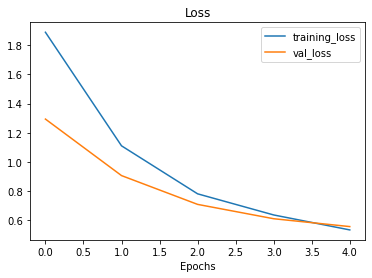

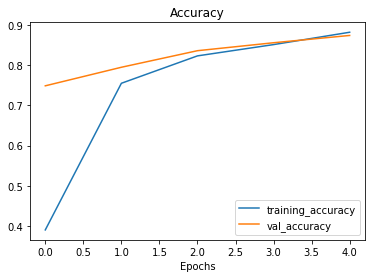

In [ ]:
plot_loss_curves(history_10_percent_ft)

### Obtenir un vecteur de caractéristiques à partir d'un modèle entraîné

La couche `tf.keras.layers.GlobalAveragePooling2D()` transforme un tenseur 4D en un tenseur 2D en faisant la moyenne des valeurs sur les axes internes.



In [ ]:
input_shape = (1,4,4,3)
tf.random.set_seed(42)

input_tensor = tf.random